## 数据预处理
从json文件生成tokenized（未经embedding）后的数据集

In [40]:
!nvidia-smi

Tue Feb 28 03:04:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   37C    P0    54W / 300W |  19515MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:06.0 Off |                    0 |
| N/A   

In [41]:
import torch
print(torch.__version__)
print((torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.13.1+cu116
True
cuda


In [42]:
from datasets import load_dataset
from transformers import RobertaTokenizer

In [43]:
dataset_path = './output/tokenized_output'                # output
load_path = "./data/raw_data/nodoc_noAcceptOneSide_noNewLine.json"  # raw data
bert_path = "./bert/CodeBERTa-small-v1"
max_len = 30

dataset = load_dataset("json", data_files=load_path, field="mergeTuples")
tokenizer = RobertaTokenizer.from_pretrained(bert_path)


Found cached dataset json (/root/.cache/huggingface/datasets/json/default-f49de165d0d35ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
def res_indices(conflict):
    '''给 conflict 加上 label 和 lines
    
    Args:
        conflict: 冲突，需要有 ours, theirs, resolve
    
    Returns:
        label: resolve 对应在 lines 里的行号
        lines: ours+theirs 的所有行
    '''
    code_lines = []
    if conflict['ours']:
        code_lines = conflict['ours'][:]
    if conflict['theirs']:
        code_lines += conflict['theirs'][:]
    indices = []
    if conflict['resolve']:
        for line in conflict['resolve']:
            for i in range(len(code_lines)):
                if line == code_lines[i]:
                    indices.append(i)
                    break
    return {'label': indices, 'lines': code_lines}


def padding(example, max_len):
    '''给一个冲突样本加入填充
    
    <pad> 对应 0
    <eos> 对应超过lines的行数的数
    
    Args:
        max_len: a+b+<eos>的总行数不应超过 max_len，resolution+<eos> 也不应该超过max_len
        example: 一个样本，需要保证加入一个<eos>不会超过最长max_len
    '''
    valid_len = len(example['label'])
    pad_lines = example['lines'] + ['<eos>']
    pad_label = example['label'] + [len(example['lines'])]

    for i in range(max_len - len(example['lines']) - 1): # 填充到max_len
        pad_lines = pad_lines + ['<pad>']
    for i in range(max_len - valid_len - 1):
        pad_label = pad_label + [0]

    # padding resolve
    pad_resolve = example['resolve'] + ['<eos>']
    for i in range(max_len - len(example['resolve']) - 1):
        pad_resolve = pad_resolve + ['<pad>']                   # 注意 resolution 没加 eos   为什么没加，我先加上

    return {
        'resolve': pad_resolve,
        'lines': pad_lines,
        'label': pad_label,
        'valid_len': valid_len + 1
    }


def tokenize_func(example):
    return tokenizer(example['lines'], padding='max_length', truncation=True, return_tensors="pt")


# def embedding_func(example):
#     return {'hidden_state': codeBert(torch.tensor(example['input_ids']), torch.tensor(example['attention_mask']))[
#         'pooler_output']}


In [45]:
print('compute resolution indices')
label_dataset = dataset.map(res_indices, remove_columns=['ours', 'theirs', 'base'])
print(len(label_dataset['train']))

print('filter large conflicts')
filter_dataset = label_dataset.filter(lambda data: len(data['lines']) < max_len - 1 and len(data['label']) < max_len - 1) # max_len - 1 因为要给stop token留位置
print(len(filter_dataset['train']))

print('padding')
padding_dataset = filter_dataset.map(lambda x: padding(x, max_len))
print(len(padding_dataset['train']))

print("tokenizing")
# tokenized_dataset = padding_dataset.map(tokenize_func, remove_columns=['lines'])
tokenized_dataset = padding_dataset.map(tokenize_func)
print(len(tokenized_dataset['train']))

tokenized_dataset.save_to_disk(dataset_path)

Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-f49de165d0d35ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-b0467dc123f9ba3f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-f49de165d0d35ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-c7cbf062d7bc7682.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-f49de165d0d35ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-5b90c3417292ae00.arrow


compute resolution indices
15877
filter large conflicts
14586
padding
14586
tokenizing


Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-f49de165d0d35ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51/cache-e99f25e43681134b.arrow


14586


Saving the dataset (0/3 shards):   0%|          | 0/14586 [00:00<?, ? examples/s]

## Pointer Network

In [46]:
import torch
import torch.nn as nn
from torch.nn import Parameter

In [47]:
class Encoder(nn.Module):
    """
    Encoder class for Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim,
                 n_layers,
                 dropout,
                 bidir):
        """
        Initiate Encoder

        :param Tensor embedding_dim: Number of embbeding channels
        :param int hidden_dim: Number of hidden units for the LSTM
        :param int n_layers: Number of layers for LSTMs
        :param float dropout: Float between 0-1
        :param bool bidir: Bidirectional
        """

        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim // 2 if bidir else hidden_dim
        self.n_layers = n_layers * 2 if bidir else n_layers
        self.bidir = bidir
        self.lstm = nn.LSTM(embedding_dim,
                            self.hidden_dim,
                            n_layers,
                            dropout=dropout,
                            bidirectional=bidir)

        # Used for propagating .cuda() command
        self.h0 = Parameter(torch.zeros(1), requires_grad=False)
        self.c0 = Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, embedded_inputs,
                hidden):
        """
        Encoder - Forward-pass

        :param Tensor embedded_inputs: Embedded inputs of Pointer-Net
        :param Tensor hidden: Initiated hidden units for the LSTMs (h, c)
        :return: LSTMs outputs and hidden units (h, c)
        """

        embedded_inputs = embedded_inputs.permute(1, 0, 2)  # [30 * 32 * 768]

        outputs, hidden = self.lstm(embedded_inputs, hidden)
        # LSTM  input   -> (L, N, H_in), (h_0, c_0)
        #       output  -> (L, N, D*H_out), (h_n, c_n)

        return outputs.permute(1, 0, 2), hidden # [32 * 30 * 768]   这个尺寸不对吧？ outputs应该是[32, 30, 1024], hidden[]

    def init_hidden(self, embedded_inputs):
        """
        Initiate hidden units

        :param Tensor embedded_inputs: The embedded input of Pointer-NEt
        :return: Initiated hidden units for the LSTMs (h, c)
        """

        batch_size = embedded_inputs.size(0)

        # Reshaping (Expanding)
        h0 = self.h0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hidden_dim)
        c0 = self.h0.unsqueeze(0).unsqueeze(0).repeat(self.n_layers,
                                                      batch_size,
                                                      self.hidden_dim)

        return h0, c0


In [48]:

class Attention(nn.Module):
    """
    Attention model for Pointer-Net
    """

    def __init__(self, input_dim,
                 hidden_dim):
        """
        Initiate Attention

        :param int input_dim: Input's diamention
        :param int hidden_dim: Number of hidden units in the attention
        """

        super(Attention, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.context_linear = nn.Conv1d(input_dim, hidden_dim, 1, 1)
        self.V = Parameter(torch.FloatTensor(hidden_dim), requires_grad=True)
        self._inf = Parameter(torch.FloatTensor([float('-inf')]), requires_grad=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()

        # Initialize vector V
        nn.init.uniform_(self.V, -1, 1)

    def forward(self, input,
                context,
                mask):
        """
        Attention - Forward-pass

        :param Tensor input: Hidden state h
        :param Tensor context: Attention context
        :param ByteTensor mask: Selection mask
        :return: tuple of - (Attentioned hidden state, Alphas)
        """

        # (batch, hidden_dim, seq_len)
        inp = self.input_linear(input).unsqueeze(2).expand(-1, -1, context.size(1))

        # (batch, hidden_dim, seq_len)
        context = context.permute(0, 2, 1)
        ctx = self.context_linear(context)

        # (batch, 1, hidden_dim)
        V = self.V.unsqueeze(0).expand(context.size(0), -1).unsqueeze(1)

        # (batch, seq_len)
        att = torch.bmm(V, self.tanh(inp + ctx)).squeeze(1)
        if len(att[mask]) > 0:
            att[mask] = self.inf[mask]
        alpha = self.softmax(att)

        hidden_state = torch.bmm(ctx, alpha.unsqueeze(2)).squeeze(2)

        return hidden_state, alpha

    def init_inf(self, mask_size):
        self.inf = self._inf.unsqueeze(1).expand(*mask_size)


class Decoder(nn.Module):
    """
    Decoder model for Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim):
        """
        Initiate Decoder

        :param int embedding_dim: Number of embeddings in Pointer-Net
        :param int hidden_dim: Number of hidden units for the decoder's RNN
        """

        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.input_to_hidden = nn.Linear(embedding_dim, 4 * hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, 4 * hidden_dim)
        self.hidden_out = nn.Linear(hidden_dim * 2, hidden_dim)
        self.att = Attention(hidden_dim, hidden_dim)

        # Used for propagating .cuda() command
        self.mask = Parameter(torch.ones(1), requires_grad=False)
        self.runner = Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, embedded_inputs,
                decoder_input,
                hidden,
                context):
        """
        Decoder - Forward-pass

        :param Tensor embedded_inputs: Embedded inputs of Pointer-Net
        :param Tensor decoder_input: First decoder's input
        :param Tensor hidden: First decoder's hidden states
        :param Tensor context: Encoder's outputs
        :return: (Output probabilities, Pointers indices), last hidden state
        """

        batch_size = embedded_inputs.size(0)
        input_length = embedded_inputs.size(1)

        # (batch, seq_len)
        mask = self.mask.repeat(input_length).unsqueeze(0).repeat(batch_size, 1)
        self.att.init_inf(mask.size())

        # Generating arang(input_length), broadcasted across batch_size
        runner = self.runner.repeat(input_length)
        for i in range(input_length):
            runner.data[i] = i
        runner = runner.unsqueeze(0).expand(batch_size, -1).long()

        outputs = []
        pointers = []

        def step(x, hidden):
            """
            Recurrence step function

            :param Tensor x: Input at time t
            :param tuple(Tensor, Tensor) hidden: Hidden states at time t-1
            :return: Hidden states at time t (h, c), Attention probabilities (Alpha)
            """

            # Regular LSTM
            h, c = hidden

            gates = self.input_to_hidden(x) + self.hidden_to_hidden(h)
            input, forget, cell, out = gates.chunk(4, 1)

            input = torch.sigmoid(input)
            forget = torch.sigmoid(forget)
            cell = torch.tanh(cell)
            out = torch.sigmoid(out)

            c_t = (forget * c) + (input * cell)
            h_t = out * torch.tanh(c_t)

            # Attention section
            hidden_t, output = self.att(h_t, context, torch.eq(mask, 0))
            hidden_t = torch.tanh(self.hidden_out(torch.cat((hidden_t, h_t), 1)))

            return hidden_t, c_t, output

        # Recurrence loop
        for _ in range(input_length):
            h_t, c_t, outs = step(decoder_input, hidden)
            hidden = (h_t, c_t)

            # Masking selected inputs
            masked_outs = outs * mask

            # Get maximum probabilities and indices
            max_probs, indices = masked_outs.max(1)
            one_hot_pointers = (runner == indices.unsqueeze(1).expand(-1, outs.size()[1])).float()

            # Update mask to ignore seen indices
            mask = mask * (1 - one_hot_pointers)

            # Get embedded inputs by max indices
            embedding_mask = one_hot_pointers.unsqueeze(2).expand(-1, -1, self.embedding_dim).byte()
            decoder_input = embedded_inputs[embedding_mask.data].view(batch_size, self.embedding_dim)

            outputs.append(outs.unsqueeze(0))
            pointers.append(indices.unsqueeze(1))

        outputs = torch.cat(outputs).permute(1, 0, 2)
        pointers = torch.cat(pointers, 1)

        return (outputs, pointers), hidden


In [49]:
class Embedding(nn.Module):
    def __init__(self, codeBERT, batch_size):
        super(Embedding, self).__init__()
        self.bert = codeBERT
        self.batch = batch_size

    def forward(self, input_ids, attention_mask):   # 两个参数都是 batchsize * max_line * token后长度  (32*30*512)
        ret = self.bert(input_ids[0:self.batch], attention_mask[0:self.batch])['pooler_output']
        for i in range(len(input_ids) // self.batch):   
            if i == 0:
                continue
            cur = self.bert(input_ids[self.batch * i: self.batch * (i + 1)], attention_mask[self.batch * i: self.batch * (i + 1)])['pooler_output']
            ret = torch.cat([ret, cur], 0)  # 这里这么做是保证所有batch都被embedding
        return ret  # 960*768


class PointerNet(nn.Module):
    """
    Pointer-Net
    """

    def __init__(self, embedding_dim,
                 hidden_dim,
                 lstm_layers,
                 dropout,
                 embed_batch,
                 bert,
                 bidir=False,):
        """
        Initiate Pointer-Net

        :param int embedding_dim: Number of embbeding channels      768
        :param int hidden_dim: Encoders hidden units
        :param int lstm_layers: Number of layers for LSTMs
        :param float dropout: Float between 0-1
        :param bool bidir: Bidirectional
        """

        super(PointerNet, self).__init__()
        self.embedding_dim = embedding_dim
        self.bidir = bidir
        # self.embedding = nn.Linear(2, embedding_dim)
        self.bert = bert
        self.embed_batch = embed_batch
        self.embedding = Embedding(self.bert, embed_batch)
        self.encoder = Encoder(embedding_dim,
                               hidden_dim,
                               lstm_layers,
                               dropout,
                               bidir)
        self.decoder = Decoder(embedding_dim, hidden_dim)
        self.decoder_input0 = Parameter(torch.FloatTensor(embedding_dim), requires_grad=False)

        # Initialize decoder_input0
        nn.init.uniform_(self.decoder_input0, -1, 1)

    def forward(self, inputs):
        """
        PointerNet - Forward-pass

        :param Tensor inputs: Input sequence
        :return: Pointers probabilities and indices
        """

        batch_size = inputs[0].size(0)

        decoder_input0 = self.decoder_input0.unsqueeze(0).expand(batch_size, -1)

        input_ids = inputs[0]
        att_mask = inputs[1]

        # embedding
        input_ids = input_ids.view(-1, input_ids.size()[-1])    # 32*30*512 -> 960 * 512
        att_mask = att_mask.view(-1, att_mask.size()[-1])       # 32*30*512 -> 960 * 512
        embedded_inputs = self.embedding(input_ids, att_mask)   # 960 * 512 -> 960 * 768
        embedded_inputs = embedded_inputs.view(batch_size, -1, embedded_inputs.size()[-1])  # 960 * 768 -> 32 * 30 * 768

        # encoder
        encoder_hidden0 = self.encoder.init_hidden(embedded_inputs)
            # 输出  encoder_outputs [32, 30, D * H_out]  D = 2 if bidirection    H_out = 1024
            #       encoder_hidden (h_n, c_n)    ([2*4, 1024], [2*4, 1024])   双向四层
        encoder_outputs, encoder_hidden = self.encoder(embedded_inputs,
                                                       encoder_hidden0)
        
        # decoder 第一个decoder的隐状态是最后一个encoder输出的隐状态
        if self.bidir:
            decoder_hidden0 = (torch.cat((encoder_hidden[0][-2], encoder_hidden[0][-1]), dim=-1),
                               torch.cat((encoder_hidden[0][-2], encoder_hidden[0][-1]), dim=-1))       # todo: 这里为什么不是[1][-2]
                            # ([2048], [2048])
        else:
            decoder_hidden0 = (encoder_hidden[0][-1],
                               encoder_hidden[1][-1])


        (outputs, pointers), decoder_hidden = self.decoder(embedded_inputs,
                                                           decoder_input0,      # decoder 第一个输入
                                                           decoder_hidden0,     # decoder 第一个hidden state
                                                           encoder_outputs)     # context 输出

        return outputs, pointers


## Train

In [50]:
import random

import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import RobertaModel
import numpy as np
import argparse
from tqdm import tqdm

In [51]:
class ObjectDict:
  pass

params = ObjectDict()
params.batch_size = 32
params.nof_epoch = 20
params.lr = 0.01
params.gpu = True
params.embedding_size = 768
params.hiddens = 1024
params.nof_lstms = 4
params.dropout = 0.4
params.bidir = True
params.embed_batch = 1
params.bert_grad = False
params.codeBERT = './bert/CodeBERTa-small-v1'
# params.dataset = './data/tokenized/train',
params.save_path = './output/finalModel4MergeBertData.pt'

In [52]:
if params.gpu and torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
else:
    USE_CUDA = False
    print('Using CPU')

Using GPU, 2 devices.


In [53]:
embed_model = RobertaModel.from_pretrained(params.codeBERT)

if not params.bert_grad:
    for param in embed_model.parameters():
        param.requires_grad_(False)

model = PointerNet(params.embedding_size,
                   params.hiddens,
                   params.nof_lstms,
                   params.dropout,
                   params.embed_batch,
                   embed_model,
                   params.bidir, )

dataset = load_from_disk(dataset_path).with_format(type='torch')
# dataset.train_test_split(test_size=0.1)
dataset = dataset.shuffle(seed=random.randint(0, 100))['train']     # 注意这里和师兄代码有改动，师兄代码加载的DatasetDict没有splits

dataloader = DataLoader(dataset,
                        batch_size=params.batch_size,
                        shuffle=True,
                        num_workers=0)

if USE_CUDA:
    model.cuda()
    net = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True

CCE = torch.nn.CrossEntropyLoss()
model_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                model.parameters()),
                         lr=params.lr)

losses = []
max_len = 30


def max_index(tl):
    '''
    返回 list 最大值下标
    '''
    ret = 0
    max_prob = tl[0]
    for ii in range(1, len(tl)):
        if tl[ii] > max_prob:
            max_prob = tl[ii]
            ret = ii
    return ret

Some weights of the model checkpoint at ./bert/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
## temp 测试################

iterator = iter(dataloader)
# for i_batch, sample_batched in enumerate(iterator):
sample_batched = next(iterator)

sample_batched['lines'][20]

input_batch = Variable(sample_batched['input_ids'])         # 32 * 30 * 512     tokenized 后的每一行
att_batch = Variable(sample_batched['attention_mask'])      # 32 * 30 * 512     tokenized 后的每一行 token 中有效的部分（01矩阵）
target_batch = Variable(sample_batched['label'])            # 32 * 30          resolution 的行号排序

if USE_CUDA:
    input_batch = input_batch.cuda()
    att_batch = att_batch.cuda()
    target_batch = target_batch.cuda()

# 改成不用batch试试
model = PointerNet(params.embedding_size,
            params.hiddens,
            params.nof_lstms,
            params.dropout,
            params.embed_batch,
            embed_model,
            params.bidir, )
zs = []
valid_len_batch = sample_batched['valid_len']
# print(valid_len_batch)
# print(sample_batched['label'][0:2])

# for i in range(params.batch_size):
#     probabilities, indices = model([input_batch[i:i+1, 0:valid_len_batch[i]], att_batch[i:i+1, 0:valid_len_batch[i]]]) # valid_len_batch
#     z = torch.zeros(1,30,30)
#     for i in range(probabilities.shape[1]):
#         for j in range(probabilities.shape[1]):
#             z[0, i, j] = probabilities[0, i, j]
#     zs.append(z)
# o = torch.concat(zs)

In [55]:
for epoch in range(params.nof_epoch):
    batch_loss = []
    batch_acc = 0
    iterator = tqdm(dataloader, unit='Batch')

    for i_batch, sample_batched in enumerate(iterator):
        iterator.set_description('Epoch %i/%i' % (epoch + 1, params.nof_epoch))

        input_batch = sample_batched['input_ids']         # 32 * 30 * 512     tokenized 后的每一行
        att_batch = sample_batched['attention_mask']      # 32 * 30 * 512     tokenized 后的每一行 token 中有效的部分（01矩阵）
        target_batch = sample_batched['label']            # 32 * 30          resolution 的行号排序



        # if USE_CUDA:
        #     input_batch = input_batch.cuda()
        #     att_batch = att_batch.cuda()
        #     target_batch = target_batch.cuda()
        
       # 改成不用batch试试
        model = PointerNet(params.embedding_size,
                    params.hiddens,
                    params.nof_lstms,
                    params.dropout,
                    params.embed_batch,
                    embed_model,
                    params.bidir, )
        if USE_CUDA:
            input_batch = input_batch.cuda()
            att_batch = att_batch.cuda()
            target_batch = target_batch.cuda()
            model = model.cuda()

        zs = []
        # valid_len_batch = sample_batched['lines'] # bug
        for i in range(len(sample_batched['label'])):   # 0-32
            max_lines = max(sample_batched['label'][i]) + 1 # 拿到的是 lines 中<eos> 的索引 + 1
            # print(max_lines)
            probabilities, indices = model([input_batch[i:i+1, 0:max_lines], att_batch[i:i+1, 0:max_lines]]) # valid_len_batch
            z = torch.zeros(1,30,30)
            for i in range(probabilities.shape[1]):
                for j in range(probabilities.shape[1]):
                    z[0, i, j] = probabilities[0, i, j]
            zs.append(z)
        o = torch.concat(zs)


        # o, p = model([input_batch, att_batch])

        valid_len_batch = sample_batched['valid_len']               # label 加入终止符后的长度
        cur_batch_size = len(valid_len_batch)

        pred = torch.tensor([max_index(probs) for example in o for probs in example], dtype=torch.int64)
        pred = pred.view(cur_batch_size, max_len)
        if USE_CUDA:
            pred = pred.cuda()
        for i in range(len(valid_len_batch)):

            # print("valid length: ")
            # print(valid_len_batch[i])
            # print("prediction")
            # print(pred[i])
            # print('-'*40)
            # print('truth')
            # print(target_batch[i])
            # print('*'*20)

            if pred[i][0:valid_len_batch[i]].equal(target_batch[i][0:valid_len_batch[i]]):
                batched_lines = sample_batched['lines']
                batched_resolve = sample_batched['resolve']
                # print('*'*10 + 'ALL LINES' + '*'*10)
                # for line in [t[i] for t in batched_lines]:
                #     print(line)

                # print('*'*10 + 'GROUND TRUTH' + '*'*10)
                # for line in [t[i] for t in batched_resolve]:
                #     print(line)
                
                # print('*'*10 + 'PREDICTION' + '*'*10)
                # print(pred[i][0:valid_len_batch[i]])
                # print(target_batch[i][0:valid_len_batch[i]])

                batch_acc += 1

        mask_tensor = torch.zeros(size=(o.size()[:2]))
        for i in range(o.size()[0]):
            mask_tensor[i][0:valid_len_batch[i]] = 1

        if USE_CUDA:
            mask_tensor = mask_tensor.cuda()
            o = o.cuda()

        mask_tensor = mask_tensor.view(-1)

        o = o.contiguous().view(-1, o.size()[-1])
        target_batch = target_batch.view(-1)

        loss = CCE(o, target_batch)

        loss = torch.mul(loss, mask_tensor)
        loss = loss.sum() / valid_len_batch.sum()

        losses.append(loss.data)
        batch_loss.append(loss.data.cpu())

        model_optim.zero_grad()
        loss.backward()
        model_optim.step()

        iterator.set_postfix(loss='{}'.format(loss.data))

    print('Epoch {0} / {1}, average loss : {2} , average accuracy : {3}'.
          format(epoch + 1, params.nof_epoch, np.average(batch_loss), batch_acc / len(dataset)))

torch.save(model.state_dict(), params.save_path)


Epoch 1/20:   0%|          | 0/456 [00:00<?, ?Batch/s]/tmp/ipykernel_26841/519902912.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = self.softmax(att)
/tmp/ipykernel_26841/519902912.py:169: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  decoder_input = embedded_inputs[embedding_mask.data].view(batch_size, self.embedding_dim)
Epoch 1/20: 100%|██████████| 456/456 [24:41<00:00,  3.25s/Batch, loss=3.3726115226745605]


Epoch 1 / 20, average loss : 3.3747167587280273 , average accuracy : 0.02948032359797066


Epoch 2/20: 100%|██████████| 456/456 [24:10<00:00,  3.18s/Batch, loss=3.382827043533325] 


Epoch 2 / 20, average loss : 3.374718427658081 , average accuracy : 0.02564102564102564


Epoch 4/20: 100%|██████████| 456/456 [23:58<00:00,  3.15s/Batch, loss=3.3820292949676514]


Epoch 4 / 20, average loss : 3.3748669624328613 , average accuracy : 0.02577814342520225


Epoch 5/20: 100%|██████████| 456/456 [24:18<00:00,  3.20s/Batch, loss=3.351550579071045] 


Epoch 5 / 20, average loss : 3.3737101554870605 , average accuracy : 0.02509255450431921


Epoch 6/20: 100%|██████████| 456/456 [24:04<00:00,  3.17s/Batch, loss=3.3776144981384277]


Epoch 6 / 20, average loss : 3.374751091003418 , average accuracy : 0.026120937885643767


Epoch 7/20: 100%|██████████| 456/456 [23:57<00:00,  3.15s/Batch, loss=3.3811774253845215]


Epoch 7 / 20, average loss : 3.3743181228637695 , average accuracy : 0.02399561223090635


Epoch 8/20: 100%|██████████| 456/456 [24:05<00:00,  3.17s/Batch, loss=3.382931709289551] 


Epoch 8 / 20, average loss : 3.3747451305389404 , average accuracy : 0.025572466748937338


Epoch 9/20: 100%|██████████| 456/456 [24:14<00:00,  3.19s/Batch, loss=3.389472007751465] 


Epoch 9 / 20, average loss : 3.3745646476745605 , average accuracy : 0.02653229123817359


Epoch 10/20: 100%|██████████| 456/456 [23:58<00:00,  3.15s/Batch, loss=3.3668739795684814]


Epoch 10 / 20, average loss : 3.374253749847412 , average accuracy : 0.02529823118058412


Epoch 12/20: 100%|██████████| 456/456 [24:10<00:00,  3.18s/Batch, loss=3.3804526329040527]


Epoch 12 / 20, average loss : 3.3742504119873047 , average accuracy : 0.026600850130261894


Epoch 17/20: 100%|██████████| 456/456 [25:04<00:00,  3.30s/Batch, loss=3.367018699645996] 


Epoch 17 / 20, average loss : 3.374025344848633 , average accuracy : 0.026395173453996983


Epoch 18/20: 100%|██████████| 456/456 [25:26<00:00,  3.35s/Batch, loss=3.3685669898986816]


Epoch 18 / 20, average loss : 3.375220537185669 , average accuracy : 0.02598382010146716


Epoch 19/20:  90%|█████████ | 411/456 [22:00<02:27,  3.28s/Batch, loss=3.376279354095459] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 绘制 Loss

In [4]:
res = []
with open('./03101123.out') as f:
    line = f.readline()
    while line:
        splitted = line.split('accuracy : ')
        if len(splitted) > 1:
            num = float(splitted[1][:-2])
            res.append(num)
        line = f.readline()
res

[2.7834910187851363,
 2.632661456190868,
 2.4612642259701083,
 2.4475524475524475,
 2.6258055669820375,
 2.4681201151789387,
 2.5298231180584123,
 2.6395173453996983,
 2.598382010146716,
 2.6258055669820375,
 2.5709584533113947,
 2.406417112299465,
 2.6463732346085287,
 2.6737967914438503,
 2.66694090223502,
 2.687508569861511,
 2.5709584533113947,
 2.6463732346085287,
 2.4612642259701083,
 2.5298231180584123,
 2.5778143425202247,
 2.687508569861511,
 2.701220348279172,
 2.6052378993555463,
 2.420128890717126,
 2.598382010146716,
 2.5915261209378855,
 2.7560674619498147,
 2.810914575620458,
 2.2555875497051967,
 2.7560674619498147,
 2.296722884958179,
 3.0028794734677087,
 2.440696558343617,
 2.5366790072672427,
 2.564102564102564,
 2.708076237488002,
 2.687508569861511,
 2.632661456190868,
 2.8383381324557795,
 2.5778143425202247,
 2.4612642259701083,
 2.6463732346085287,
 2.543534896476073,
 2.543534896476073,
 2.6052378993555463,
 2.474976004387769,
 2.5023995612230907,
 2.810914575

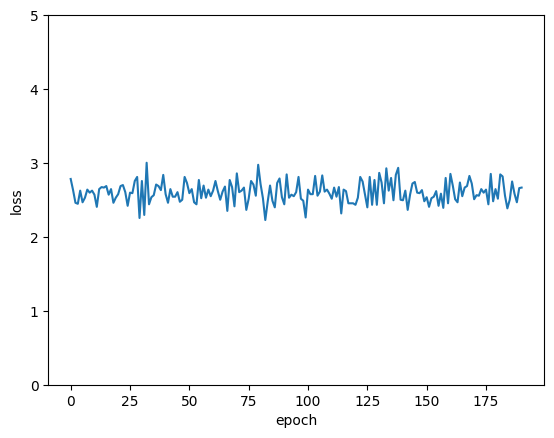

In [5]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0.0, 5.0)
plt.plot(res)